# New Approach

In [ ]:
!pip install nltk tqdm
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

# Import required libraries
import numpy as np
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import time

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/sentiment-analysis-is-bad/data/sentiment140-subset.csv.zip -P data
!unzip -n -d data data/sentiment140-subset.csv.zip

# Load the dataset
df = pd.read_csv("data/sentiment140-subset.csv")
dataset = df[['polarity', 'text']]

# Check the unique values in the 'polarity' column
print(dataset['polarity'].unique())

# Balance the dataset - Adjust the polarity values based on the output of the print statement above
minority_count = dataset['polarity'].value_counts().min()
balanced_df = pd.concat([
    dataset[dataset['polarity'] == 0].sample(minority_count, replace=False),
    dataset[dataset['polarity'] == 1].sample(minority_count, replace=False),
]).sample(frac=1).reset_index(drop=True)

# Check the class distribution after balancing
print(balanced_df['polarity'].value_counts())

File ‘data/sentiment140-subset.csv.zip’ already there; not retrieving.

Archive:  data/sentiment140-subset.csv.zip
[0 1]
polarity
0    249725
1    249725
Name: count, dtype: int64


In [ ]:
def preprocess(textdata):
    processedText = []
    wordLemm = WordNetLemmatizer()
    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern = '@[^\s]+'
    alphaPattern = "[^a-zA-Z0-9]"
    sequencePattern = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    for tweet in tqdm(textdata, desc="Processing tweets", unit="tweet"):
        tweet = str(tweet).lower()
        tweet = re.sub(urlPattern, ' URL', tweet)
        tweet = re.sub(userPattern, ' USER', tweet)
        tweet = re.sub(alphaPattern, " ", tweet)
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        tweetwords = ''
        for word in tweet.split():
            word = wordLemm.lemmatize(word)
            tweetwords += (word + ' ')
        processedText.append(tweetwords)
    return processedText

processed_text = preprocess(balanced_df['text'].values)

Processing tweets: 100%|██████████| 499450/499450 [00:47<00:00, 10554.98tweet/s]


In [ ]:
max_features = 10000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(processed_text)
X = tokenizer.texts_to_sequences(processed_text)
X = pad_sequences(X, maxlen=50)

In [ ]:
Y = balanced_df['polarity'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential()
model.add(Embedding(max_features, 128, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

history = model.fit(X_train, Y_train, epochs=10, batch_size=64, validation_split=0.1, callbacks=[early_stopping, reduce_lr])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
5619/5619 ━━━━━━━━━━━━━━━━━━━━ 765s 135ms/step - accuracy: 0.7679 - loss: 0.4797 - val_accuracy: 0.8075 - val_loss: 0.4167 - learning_rate: 0.0010
Epoch 2/10
5619/5619 ━━━━━━━━━━━━━━━━━━━━ 801s 135ms/step - accuracy: 0.8180 - loss: 0.3987 - val_accuracy: 0.8164 - val_loss: 0.4035 - learning_rate: 0.0010
Epoch 3/10
5619/5619 ━━━━━━━━━━━━━━━━━━━━ 803s 135ms/step - accuracy: 0.8320 - loss: 0.3731 - val_accuracy: 0.8170 - val_loss: 0.4035 - learning_rate: 0.0010
Epoch 4/10
5619/5619 ━━━━━━━━━━━━━━━━━━━━ 806s 136ms/step - accuracy: 0.8411 - loss: 0.3552 - val_accuracy: 0.8171 - val_loss: 0.4048 - learning_rate: 0.0010
Epoch 5/10
5619/5619 ━━━━━━━━━━━━━━━━━━━━ 795s 135ms/step - accuracy: 0.8486 - loss: 0.3411 - val_accuracy: 0.8152 - val_loss: 0.4163 - learning_rate: 0.0010


In [ ]:
Y_pred = model.predict(X_test)
Y_pred = np.round(Y_pred).astype(int).flatten()
accuracy = accuracy_score(Y_test, Y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(Y_test, Y_pred, average='binary')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

3122/3122 ━━━━━━━━━━━━━━━━━━━━ 53s 17ms/step
Accuracy: 0.8168285113624988
Precision: 0.8188408707526709
Recall: 0.8146690375816668
F1 Score: 0.8167496269292016


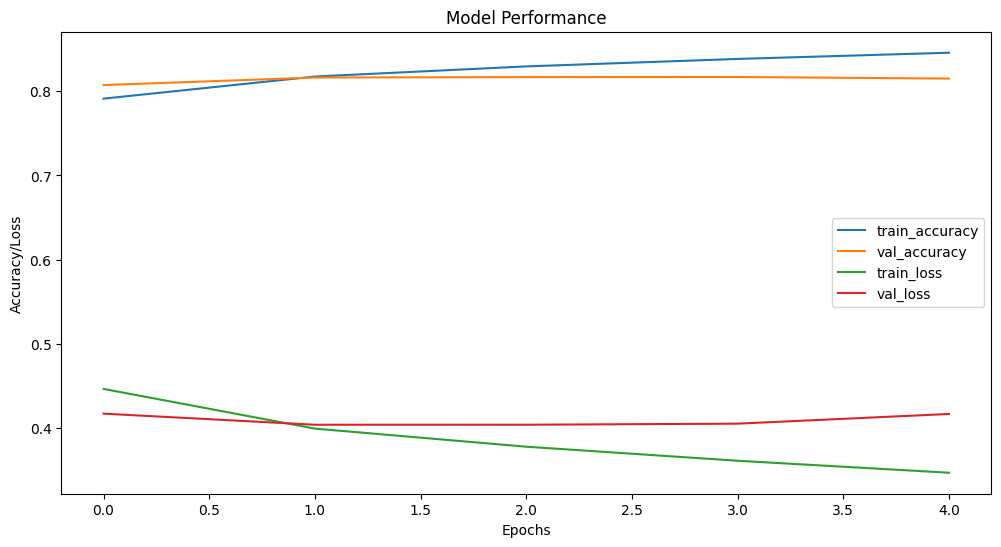

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.show()